# Monte Carlo simulation of Dynamic Risk Budgeting between PSP and GHP

We've looked at the fundamental problem of how much to allocate in the safe asset vs the performance seeking asset, and we investigated static and glidepath based techniques. Now we'll look at modern dynamic techniques that are inspired by CPPI to ensure that the account value reaches a certain target minimum floor, but also maintains exposure to the upside through a dynamic risk budget

In [1]:
import numpy as np
import pandas as pd
import edhec_risk_kit as erk
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
%load_ext autoreload
%autoreload 2

Let's start by building 500 scenarios for interest rates, an duration matched bond portfolio (proxied by a zero coupon bond) and a stock portfolio.

In [2]:
n_scenarios =  5000
rates, zc_prices = erk.cir(10, n_scenarios=n_scenarios, b=0.03, r_0 = 0.03, sigma=0.02)
price_eq = erk.gbm(n_years=10,n_scenarios=n_scenarios, mu=0.07, sigma=0.15)
rets_eq = price_eq.pct_change().dropna()
rets_zc = zc_prices.pct_change().dropna()
rets_7030b = erk.backtest_mix(rets_eq, rets_zc, allocator=erk.fixedmix_allocator, w1=0.7)
pd.concat([erk.terminal_stats(rets_zc, name="ZC", floor=0.75), 
           erk.terminal_stats(rets_eq, name="Eq", floor=0.75),
           erk.terminal_stats(rets_7030b, name="70/30", floor=0.75)],
          axis=1).round(2)

,ZC,Eq,70/30
Mean,1.34,1.95,1.74
Std,0.00,0.96,0.58
Probability breach,NaN,0.04,0.01
Expected shortfall,NaN,0.13,0.08
Probability reach,NaN,NaN,NaN
Expected surplus,NaN,NaN,NaN


Let's write a new allocator that we'll call a Floor Allocator. This applies a dynamic risk budget to allocate more to the PSP when there is a cushion, similar to what we did for CPPI

In [3]:
rets_floor75 = erk.backtest_mix(rets_eq, rets_zc, allocator=erk.floor_allocator, floor=.75,  zc_prices=zc_prices[1:])
pd.concat([erk.terminal_stats(rets_zc, name="ZC", floor=0.75), 
           erk.terminal_stats(rets_eq, name="Eq", floor=0.75),
           erk.terminal_stats(rets_7030b, name="70/30", floor=0.75),
           erk.terminal_stats(rets_floor75, name="Floor75", floor=0.75),
          ],
          axis=1).round(2)

,ZC,Eq,70/30,Floor75
Mean,1.34,1.95,1.74,1.92
Std,0.00,0.96,0.58,0.97
Probability breach,NaN,0.04,0.01,NaN
Expected shortfall,NaN,0.13,0.08,NaN
Probability reach,NaN,NaN,NaN,NaN
Expected surplus,NaN,NaN,NaN,NaN


In [4]:
rets_floor75m1 = erk.backtest_mix(rets_eq, rets_zc, allocator=erk.floor_allocator, zc_prices=zc_prices[1:], floor=.75, m=1)
pd.concat([erk.terminal_stats(rets_zc, name="ZC", floor=0.75), 
           erk.terminal_stats(rets_eq, name="Eq", floor=0.75),
           erk.terminal_stats(rets_7030b, name="70/30", floor=0.75),
           erk.terminal_stats(rets_floor75, name="Floor75", floor=0.75),
           erk.terminal_stats(rets_floor75m1, name="Floor75m1", floor=0.75),
          ],
          axis=1).round(2)

,ZC,Eq,70/30,Floor75,Floor75m1
Mean,1.34,1.95,1.74,1.92,1.61
Std,0.00,0.96,0.58,0.97,0.42
Probability breach,NaN,0.04,0.01,NaN,NaN
Expected shortfall,NaN,0.13,0.08,NaN,NaN
Probability reach,NaN,NaN,NaN,NaN,NaN
Expected surplus,NaN,NaN,NaN,NaN,NaN


In [5]:
rets_floor75m5 = erk.backtest_mix(rets_eq, rets_zc, allocator=erk.floor_allocator, zc_prices=zc_prices[1:], floor=.75, m=5)
rets_floor75m10 = erk.backtest_mix(rets_eq, rets_zc, allocator=erk.floor_allocator, zc_prices=zc_prices[1:], floor=.75, m=10)
pd.concat([erk.terminal_stats(rets_zc, name="ZC", floor=0.75), 
           erk.terminal_stats(rets_eq, name="Eq", floor=0.75),
           erk.terminal_stats(rets_7030b, name="70/30", floor=0.75),
           erk.terminal_stats(rets_floor75, name="Floor75", floor=0.75),
           erk.terminal_stats(rets_floor75m1, name="Floor75m1", floor=0.75),
           erk.terminal_stats(rets_floor75m5, name="Floor75m5", floor=0.75),
           erk.terminal_stats(rets_floor75m10, name="Floor75m10", floor=0.75)
          ],
          axis=1).round(4)

,ZC,Eq,70/30,Floor75,Floor75m1,Floor75m5,Floor75m10
Mean,1.3433,1.9486,1.7447,1.9242,1.6124,1.9344,1.9368
Std,0.0000,0.9622,0.5844,0.9675,0.4247,0.9698,0.9706
Probability breach,NaN,0.0352,0.0084,NaN,NaN,NaN,0.0224
Expected shortfall,NaN,0.1256,0.0765,NaN,NaN,NaN,0.0035
Probability reach,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Expected surplus,NaN,NaN,NaN,NaN,NaN,NaN,NaN


C:\Users\campo\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\campo\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\campo\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-lev

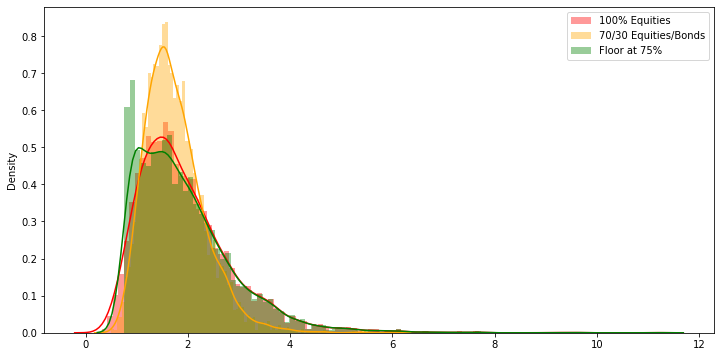

In [6]:
tv_eq = erk.terminal_values(rets_eq)
tv_zc = erk.terminal_values(rets_zc)
tv_7030b = erk.terminal_values(rets_7030b)
tv_floor75 = erk.terminal_values(rets_floor75)
tv_floor75m1 = erk.terminal_values(rets_floor75m1)
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
sns.distplot(tv_eq, color="red", label="100% Equities", bins=100)
#sns.distplot(tv_zc, color="blue", label="100% Immunized Bonds")
sns.distplot(tv_7030b, color="orange", label="70/30 Equities/Bonds", bins=100)
sns.distplot(tv_floor75, color="green", label="Floor at 75%", bins=100)

plt.legend();

C:\Users\campo\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\campo\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\campo\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-lev

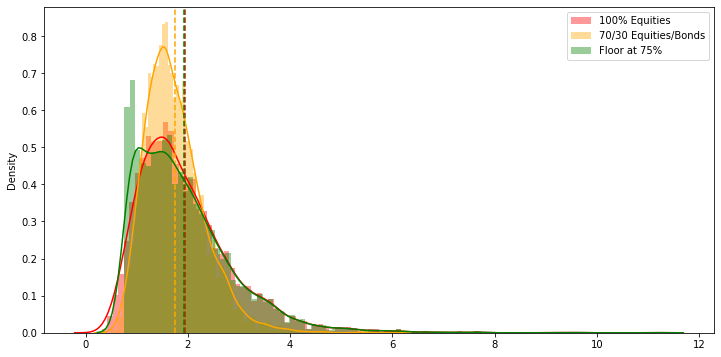

In [7]:
tv_eq = erk.terminal_values(rets_eq)
tv_zc = erk.terminal_values(rets_zc)
tv_7030b = erk.terminal_values(rets_7030b)
tv_floor75 = erk.terminal_values(rets_floor75)
tv_floor75m1 = erk.terminal_values(rets_floor75m1)
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
sns.distplot(tv_eq, color="red", label="100% Equities", bins=100)
plt.axvline(tv_eq.mean(), ls="--", color="red")
#sns.distplot(tv_zc, color="blue", label="100% Immunized Bonds")
#plt.axvline(tv_zc.mean(), ls="--", color="blue")
sns.distplot(tv_7030b, color="orange", label="70/30 Equities/Bonds", bins=100)
plt.axvline(tv_7030b.mean(), ls="--", color="orange")
sns.distplot(tv_floor75, color="green", label="Floor at 75%", bins=100)
plt.axvline(tv_floor75.mean(), ls="--", color="green")

plt.legend();

## Dynamic Risk Budgeting with Drawdown instead of a fixed floor

In [8]:
cashrate = 0.02
monthly_cashreturn = (1+cashrate)**(1/12) - 1
rets_cash = pd.DataFrame(data= monthly_cashreturn, index=rets_eq.index, columns=rets_eq.columns)
rets_maxdd25 = erk.backtest_mix(rets_eq, rets_cash, allocator=erk.drawdown_allocator, maxdd=.25)
pd.concat([erk.terminal_stats(rets_zc, name="ZC", floor=0.75), 
           erk.terminal_stats(rets_eq, name="Eq", floor=0.75),
           erk.terminal_stats(rets_7030b, name="70/30", floor=0.75),
           erk.terminal_stats(rets_floor75, name="Floor75", floor=0.75),
           erk.terminal_stats(rets_floor75m1, name="Floor75m1", floor=0.75),
           erk.terminal_stats(rets_floor75m5, name="Floor75m5", floor=0.75),
           erk.terminal_stats(rets_floor75m10, name="Floor75m10", floor=0.75),
           erk.terminal_stats(rets_maxdd25, name="MaxDD25", floor=0.75)           
          ],
          axis=1).round(2)

,ZC,Eq,70/30,Floor75,Floor75m1,Floor75m5,Floor75m10,MaxDD25
Mean,1.34,1.95,1.74,1.92,1.61,1.93,1.94,1.62
Std,0.00,0.96,0.58,0.97,0.42,0.97,0.97,0.53
Probability breach,NaN,0.04,0.01,NaN,NaN,NaN,0.02,NaN
Expected shortfall,NaN,0.13,0.08,NaN,NaN,NaN,0.00,NaN
Probability reach,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Expected surplus,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
erk.summary_stats(rets_maxdd25)["Max Drawdown"].min()

-0.23258350021877922

C:\Users\campo\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\campo\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\campo\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-lev

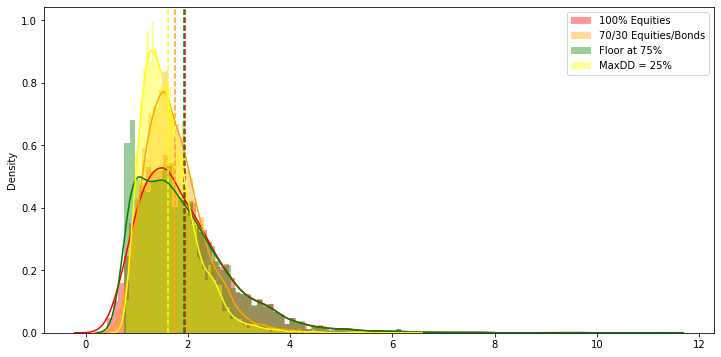

In [10]:
tv_maxdd25 = erk.terminal_values(rets_maxdd25)
# Plot
plt.figure(figsize=(12, 6))
sns.distplot(tv_eq, color="red", label="100% Equities", bins=100)
plt.axvline(tv_eq.mean(), ls="--", color="red")
#sns.distplot(tv_zc, color="blue", label="100% Immunized Bonds")
#plt.axvline(tv_zc.mean(), ls="--", color="blue")
sns.distplot(tv_7030b, color="orange", label="70/30 Equities/Bonds", bins=100)
plt.axvline(tv_7030b.mean(), ls="--", color="orange")
sns.distplot(tv_floor75, color="green", label="Floor at 75%", bins=100)
plt.axvline(tv_floor75.mean(), ls="--", color="green")
sns.distplot(tv_maxdd25, color="yellow", label="MaxDD = 25%", bins=100)
plt.axvline(tv_maxdd25.mean(), ls="--", color="yellow")
plt.legend();

## Backtesting Dynamic Strategies with Historical Data

Try and work with real historic data such as a the Industry Portfolios or the Total Market Index we constructed and run back tests with different parameter values. For instance:

<AxesSubplot:>

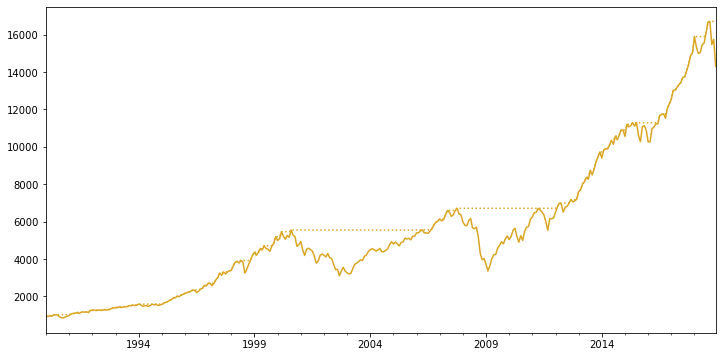

In [11]:
rets_tmi =  erk.get_total_market_index_returns()["1990":]
dd_tmi = erk.drawdown(rets_tmi)
ax = dd_tmi["Wealth"].plot(figsize=(12,6), ls="-", color="goldenrod")
dd_tmi["Previous Peak"].plot(ax=ax, ls=":", color="goldenrod")

In [17]:
rets_cash.shape

(348, 1)

<AxesSubplot:>

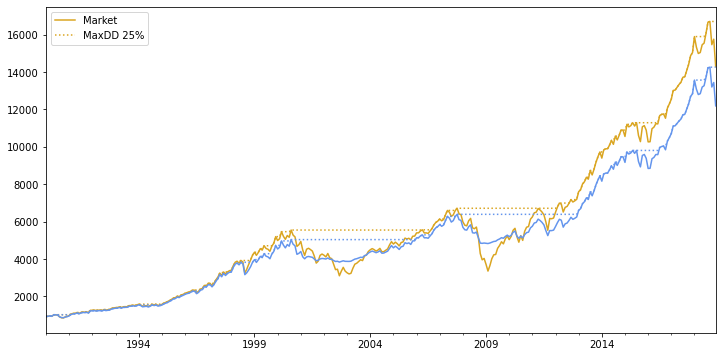

In [15]:
cashrate = 0.03
monthly_cashreturn = (1+cashrate)**(1/12) - 1
rets_cash = pd.DataFrame(data= monthly_cashreturn, index=rets_tmi.index, columns=[0]) # 1 column dataframe
rets_maxdd25 = erk.backtest_mix(pd.DataFrame(rets_tmi), rets_cash, allocator=erk.drawdown_allocator, maxdd=.25, m=5)
dd_25 = erk.drawdown(rets_maxdd25[0])

ax = dd_tmi["Wealth"].plot(figsize=(12,6), ls="-", color="goldenrod", label="Market", legend=True)
dd_tmi["Previous Peak"].plot(ax=ax, ls=":", color="goldenrod")
dd_25["Wealth"].plot(ax=ax, label="MaxDD 25%", color="cornflowerblue", legend=True)
dd_25["Previous Peak"].plot(ax=ax, color="cornflowerblue", ls=":")

In [14]:
erk.summary_stats(pd.concat([rets_tmi.rename("Market"), rets_maxdd25[0].rename("MaxDD")], axis=1))

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
Market,0.096058,0.145419,-0.668827,4.247282,0.066949,0.094633,0.441951,-0.499943
MaxDD,0.090062,0.112755,-0.630463,5.015334,0.049978,0.071074,0.518327,-0.244212
